# Spec Visualization

In [1]:
from itertools import cycle
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.colors import to_hex
from rich.progress import track

from htc.models.data.DataSpecification import DataSpecification
from htc.settings import settings
from htc.utils.visualization import compress_html
from htc_projects.camera.settings_camera import settings_camera

In [2]:
# Parameter for papermill
# Spec visualizations can easily be created via
path = "htc/models/data/pigs_semantic-only_5foldsV2.json"
mapping = None

## Spec Figure

In [3]:
path = Path(path)
spec = DataSpecification(path)
spec.activate_test_set()

# Special sorting for some specs
sortings = {
    "weak_labels_validation_concept": ["train_partial", "validation", "train_weak", "test"],
    "pigs_semantic-only_5foldsV2": ["val_semantic_unknown", "train_semantic", "val_semantic_known", "test"],
}

if path.stem in sortings.keys():
    sorting = sortings[path.stem]
elif set(spec.split_names()) == {"train", "val", "test"}:
    sorting = ["val", "train", "test"]
else:
    sorting = spec.split_names()

paths = []
for split_name in sorting:
    for fold, splits in spec:
        for p in splits[split_name]:
            if p not in paths:
                paths.append(p)

image_names = [p.image_name() for p in paths]
dataset_names = ["none", *spec.split_names()]
folds = spec.fold_names()

# Fold splits
fold_matrix = np.zeros((len(folds), len(paths)), dtype=np.int64)
for fold, splits in track(spec):
    fold_name = folds.index(fold)

    for split_name, split_paths in splits.items():
        for p in split_paths:
            path_idx = image_names.index(p.image_name())
            fold_matrix[fold_name, path_idx] = dataset_names.index(split_name)

if np.all(fold_matrix > 0):
    dataset_names.remove("none")

# Subjects
subjects = sorted({p.subject_name for p in paths})
subject_matrix = np.zeros((1, len(paths)), dtype=np.int64)

# Cameras
cams = sorted({p.meta("camera_name") for p in paths})
cam_matrix = np.zeros((1, len(paths)), dtype=np.int64)

for p in track(paths):
    path_idx = image_names.index(p.image_name())
    subject_matrix[0, path_idx] = subjects.index(p.subject_name)
    cam_matrix[0, path_idx] = cams.index(p.meta("camera_name"))

if p.meta("image_label_name") is not None:
    classes = sorted({p.meta("image_label_name") for p in paths})
    class_matrix = np.zeros((1, len(paths)), dtype=np.int64)
    for p in paths:
        path_idx = image_names.index(p.image_name())
        class_matrix[0, path_idx] = classes.index(p.meta("image_label_name"))
else:
    classes = None

# subject_name as ticks
subject_borders = []
subject_labels = []
last_subject_name = ""
for i, image_name in enumerate(image_names):
    subject_name = image_name.split("#")[0]
    if subject_name != last_subject_name:
        subject_borders.append(i)
        subject_labels.append(subject_name)
        last_subject_name = subject_name

Output()

Output()

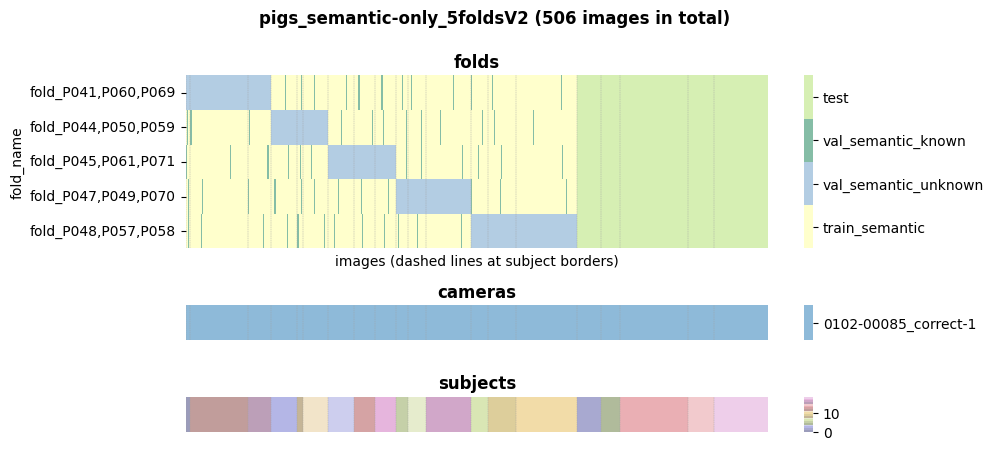

In [4]:
def set_cbar_ticks(ax, labels: list[str]) -> None:
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / len(labels) * (0.5 + i) for i in range(len(labels))])
    colorbar.set_ticklabels(labels)


dataset_colors = ["#FFFFCC", "#B3CDE3", "#85BDA6", "#D6EFB3"]
if "none" in dataset_names:
    dataset_colors = ["#FFFFFF", *dataset_colors]
assert len(dataset_names) <= len(dataset_colors), "Not enough colors for the datasets available"
dataset_colors = dataset_colors[: len(dataset_names)]

subject_colors = []
for name in cycle(["tab20b", "tab20c", "Set1", "Set2", "Set3", "Pastel1", "Pastel2", "Accent", "Dark2"]):
    for c in matplotlib.colormaps.get_cmap(name).colors:
        subject_colors.append(to_hex(c))
        if len(subject_colors) == len(subjects):
            break
    if len(subject_colors) == len(subjects):
        break

n_rows = 3 if classes is None else 4
fig, axes = plt.subplots(
    n_rows,
    1,
    tight_layout=True,
    figsize=(10, 0.3 * n_rows * len(folds)),
    edgecolor="k",
    gridspec_kw={
        "height_ratios": [len(folds)] + [1] * (n_rows - 1) if classes is None else [len(folds)] + [1] * (n_rows - 1)
    },
)

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
sns.heatmap(fold_matrix, cmap=dataset_colors, rasterized=True, ax=ax1)
sns.heatmap(
    cam_matrix,
    cmap=[settings_camera.camera_name_colors[c] for c in cams],
    alpha=0.5,
    rasterized=True,
    cbar_kws={"aspect": 4},
    ax=ax2,
)
sns.heatmap(
    subject_matrix,
    cmap=subject_colors,
    alpha=0.5,
    rasterized=True,
    cbar_kws={"aspect": 4},
    ax=ax3,
)

if classes is not None:
    ax4 = axes[3]
    colors = [to_hex(c) for c in matplotlib.colormaps.get_cmap("Set1").colors][: len(classes)]
    sns.heatmap(class_matrix, cmap=colors, rasterized=True, cbar_kws={"aspect": 4}, alpha=0.5, ax=ax4)
    set_cbar_ticks(ax4, classes)
    ax4.set_xticks([])
    ax4.set_xticklabels([])
    ax4.get_yaxis().set_visible(False)
    ax4.set_title("image label", fontweight="semibold")

for ax in axes:
    for b in subject_borders:
        ax.axvline(b, linewidth=0.3, color="#a1a1a1", linestyle="--")

ax1.set_ylabel("fold_name")
ax1.set_title("folds", fontweight="semibold")
ax1.set_xticks([])
ax1.set_yticklabels(folds, rotation=0)
set_cbar_ticks(ax1, dataset_names)
ax1.set_xlabel("images (dashed lines at subject borders)")

ax2.set_title("cameras", fontweight="semibold")
set_cbar_ticks(ax2, cams)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.get_yaxis().set_visible(False)

ax3.set_title("subjects", fontweight="semibold")
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.get_yaxis().set_visible(False)

fig.suptitle(f"{path.stem} ({len(image_names)} images in total)", fontweight="bold", y=0.99);

In [5]:
target_dir = settings.results_dir / "specs_figures"
target_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(target_dir / f"{path.stem}.pdf")

## Spec Statistics

In [6]:
rows = []
for fold_name, splits in spec:
    for split_name, paths in splits.items():
        r = {
            "fold_name": fold_name,
            "split_name": split_name,
            "# images": len(paths),
            "# subjects": len({p.subject_name for p in paths}),
            "# cams": len({p.meta("camera_name") for p in paths}),
        }
        if p.meta("image_label_name") is not None:
            names, counts = np.unique([p.meta("image_label_name") for p in paths], return_counts=True)
            for n, c in zip(names, counts, strict=True):
                r[f"# {n}"] = c

        rows.append(r)

df = pd.DataFrame(rows)
df.to_csv(target_dir / f"{path.stem}.csv", index=False)
df

,fold_name,split_name,# images,# subjects,# cams
0,"fold_P041,P060,P069",train_semantic,254,12,1
1,"fold_P041,P060,P069",val_semantic_unknown,74,3,1
2,"fold_P041,P060,P069",val_semantic_known,12,12,1
3,"fold_P041,P060,P069",test,166,5,1
4,"fold_P044,P050,P059",train_semantic,278,12,1
5,"fold_P044,P050,P059",val_semantic_unknown,50,3,1
6,"fold_P044,P050,P059",val_semantic_known,12,12,1
7,"fold_P044,P050,P059",test,166,5,1
8,"fold_P045,P061,P071",train_semantic,269,12,1
9,"fold_P045,P061,P071",val_semantic_unknown,59,3,1


In [7]:
rows = []
for fold_name, splits in spec:
    for split_name, paths in splits.items():
        for p in paths:
            labels = set()
            if mapping is not None:
                for l in p.annotated_labels():
                    if mapping.is_name_valid(l):
                        labels.add(mapping.index_to_name(mapping.name_to_index(l)))
            else:
                labels.update(p.annotated_labels())

            for l in sorted(labels):
                rows.append({
                    "fold_name": fold_name,
                    "split_name": split_name,
                    "image_name": p.image_name(),
                    "subject_name": p.subject_name,
                    "label_name": l,
                })

df_labels = pd.DataFrame(rows)
df_labels = df_labels.groupby(["fold_name", "split_name", "label_name"], as_index=False).agg(**{
    "# images": pd.NamedAgg(column="image_name", aggfunc="nunique"),
    "# subjects": pd.NamedAgg(column="subject_name", aggfunc="nunique"),
})

fig = px.bar(
    df_labels,
    x="label_name",
    y="# subjects",
    hover_data=["# images"],
    color="split_name",
    facet_col="fold_name",
    facet_col_wrap=2,
)
fig.update_layout(height=800, width=1200, template="plotly_white")
fig.update_layout(
    title_x=0.5, title_text=f"image-level label distribution for each fold and split for the spec {path.stem}"
)

compress_html(target_dir / f"{path.stem}_labels.html", fig)
fig